In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr 
import os
import geopandas as gpd
import shapely
import cmasher as cmr
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import h5py
import sys
from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [2]:
sites = [2,3,4,'grid3','grid4','grid5','grid6','grid7','grid8']

paths_MP = [
    # '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/CryoVEx2014_SEAICE_GROUNDDATA_V1/NORD_CAMP_TRANSECT.csv', #CRYOVEX 2014
    '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/ECCCEureka2014.h5', #EUREKA 2014
    '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/ECCC_2016_Eureka_Magnaprobe.csv' #EUREKA 2016
]

for year, path_MP in zip(['2014', '2016'], paths_MP):
    # load magnaprobe in situ data

    filetype = path_MP.split('.')[1]
    df_dict = open_data(path_MP, filetype=filetype, mode='dict', instrument='MP')

    if year == '2014':
        f = h5py.File(path_MP, 'r')
        group = f['eureka_data']
        data = group['magnaprobe']
        df_df = pd.DataFrame({'lat':data['latitude'][()], 'lon':data['longitude'][()], 'snow_depth':data['snow_depth'][()], 'site_id':data['site_id'][()]})
        df_df.loc[df_df['lon'] < 0, 'lon'] += 360
        df_df['ice_type'] = ['fyi']*len(df_df)
        df_df = df_df.loc[(df_df['site_id'] == 2) | (df_df['site_id'] == 3) | (df_df['site_id'] == 4)] 
        df_df.reset_index(drop=True, inplace=True)
        
    elif year == '2016':
        for key in ['grid3','grid4', 'grid5','grid6','grid7','grid8']:
            if not df_df.empty:
                df_df = pd.concat([df_df, df_dict[key]])
                
    df_df['x'], df_df['y'] = transformer.transform(df_df['lon'], df_df['lat'])

    sites = df_df['site_id'].unique()


path_to_outlines = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v3'
files = os.listdir(path_to_outlines) 
files = np.sort([f for f in files if f.endswith('.shp')])
shape_dict = {}
for f, site in zip(files,sites):
    shape_dict[site] = gpd.read_file(path_to_outlines + '/' + f)

path_to_data = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exactTrue/'
files = os.listdir(path_to_data) 
files = np.sort([f for f in files if f.endswith('.nc')])
kriging_dict = {}
for f,site in zip(files,sites):
    print(f)
    kriging_dict[site] = xr.open_dataset(os.path.join(path_to_data,f))  
    kriging_dict[site] = kriging_dict[site].rio.set_spatial_dims(x_dim='easting', y_dim='northing')


/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/ECCC_2016_Eureka_Magnaprobe.csv


/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Scripts/msc_thesis_functions.py:521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time.loc[weird_indices] = np.nan


EUREKA2014_2_krigged_MP_snow_depth.nc
EUREKA2014_3_krigged_MP_snow_depth.nc
EUREKA2014_4_krigged_MP_snow_depth.nc
EUREKA2016_grid3_krigged_MP_snow_depth.nc
EUREKA2016_grid4_krigged_MP_snow_depth.nc
EUREKA2016_grid5_krigged_MP_snow_depth.nc
EUREKA2016_grid6_krigged_MP_snow_depth.nc
EUREKA2016_grid7_krigged_MP_snow_depth.nc
EUREKA2016_grid8_krigged_MP_snow_depth.nc


### MAP OVERVIEW PLOT

/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_80557/2646154109.py:59: UserWarning: linewidths is ignored by contourf
  ax[i].contourf(clipped.easting.values, clipped.northing.values, clipped['classes'].values,
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_80557/2646154109.py:59: UserWarning: linewidths is ignored by contourf
  ax[i].contourf(clipped.easting.values, clipped.northing.values, clipped['classes'].values,
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/var/folders/3

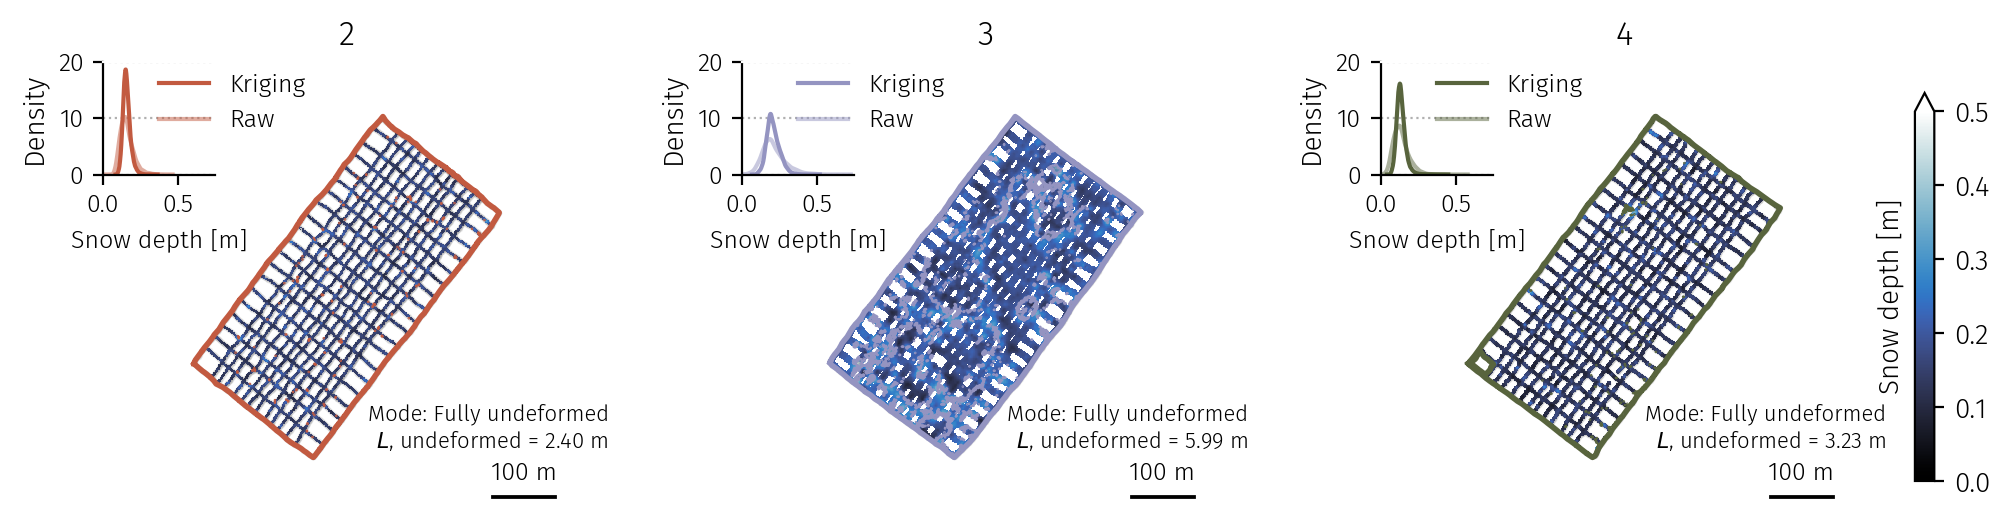

In [3]:
norm = mcolors.Normalize(vmin=0, vmax=.5)
colors =  ["#c25a40",
"#9494c1",
"#58643d"]
sites_2014 = [2,3,4]
fig, ax = plt.subplots(1,3,figsize=(12,10), constrained_layout=True, dpi=200)   
ax = ax.ravel()
insets = [None]*len(ax)

for ind in range(len(ax)):
    ax[ind].set_aspect('equal')
    ax[ind].set_title(sites_2014[ind])
    ax[ind].axis('off')
    
    # if ind == 2:
    #     insets[ind] = ax[ind].inset_axes([0.7, 0.7, 0.3, 0.3])
    # else:
    insets[ind] = ax[ind].inset_axes([-0.15, 0.8, 0.3, 0.3])
    insets[ind].set_xlim(0,.75)
    insets[ind].set_ylim(0,20)
    insets[ind].set_xlabel('Snow depth [m]', fontsize=9)
    insets[ind].tick_params(axis='both', which='major', labelsize=9)
    insets[ind].spines['top'].set_color('white')
    insets[ind].spines['right'].set_color('white')
    insets[ind].grid(ls=':',axis='y')
    
for i, site in enumerate(sites_2014):
    df_insitu = df_df.loc[df_df['site_id'] == site]
    
    for geom in shape_dict[site].geometry:
        if type(geom) == shapely.geometry.multipolygon.MultiPolygon:
            for j, g in enumerate(geom):
                ax[i].plot(g.exterior.xy[0], g.exterior.xy[1], color=colors[i], lw=2, zorder=100)
                            # ax[0].plot(shape_dict[site].geometry[0].geoms[0].exterior.xy[0], shape_dict[site].geometry[0].geoms[0].exterior.xy[1], color='black', lw=1, zorder=100, label='Site boundary')
        else:
                ax[i].plot(geom.exterior.xy[0], geom.exterior.xy[1], color=colors[i], lw=2, zorder=100, label='Site boundary')
    
    xlim = ax[i].get_xlim()
    
    width = xlim[1] - xlim[0]
    ylim = ax[i].get_ylim()
    height = ylim[1] - ylim[0]
    diff = height - width
    ax[i].scatter(df_insitu['x'], df_insitu['y'], alpha=.1, s=1,color='grey')
    
    pcol = ax[i].pcolormesh(kriging_dict[site].easting.values, kriging_dict[site].northing.values, kriging_dict[site]['snow_depth'].values,
                     cmap=cmr.arctic,
                     norm=norm
                     )
    clipped = kriging_dict[site].rio.clip([shape_dict[site].geometry[0]])
    
    ax[i].contour(clipped.easting.values, clipped.northing.values, clipped['classes'].values,
                  linewidths=.754,
                  colors=colors[i],
                  levels=[0.5],
                #   alpha=.3,
                  zorder=200
                  )
    ax[i].contourf(clipped.easting.values, clipped.northing.values, clipped['classes'].values,
                  linewidths=.754,
                  cmap='Greys',
                  levels=[0.5,1.5],
                  alpha=.4,
                  zorder=100
                  )

    
    if diff > 0:
        ax[i].set_xlim(xlim[0]-diff/2, xlim[1] + diff/2) 
        ax[i].set_ylim(ylim)
    else:
        ax[i].set_xlim(xlim)
        ax[i].set_ylim(ylim[0]-diff/2, ylim[1] + diff/2)

    
    # sns.histplot(kriging_dict[site]['snow_depth'].values[~np.isnan(kriging_dict[site]['snow_depth'].values)],
    #             bins=np.linspace(0,1,25),
    #             stat='percent',
    #             ax=insets[i],
    #             line_kws={'color':None},
    #             color=colors[i]
    #             )
    sns.kdeplot(kriging_dict[site]['snow_depth'].values[~np.isnan(kriging_dict[site]['snow_depth'].values)],
                # bins=np.linspace(0,1,25),
                # stat='percent',
                ax=insets[i],
                # line_kws={'color':None},
                color=colors[i],
                label='Kriging'
                )
    sns.kdeplot(df_insitu['snow_depth'],
                # bins=np.linspace(0,1,25),
                # stat='percent',
                ax=insets[i],
                # line_kws={'color':None},
                color=colors[i],
                alpha=.5,
                label='Raw'
                )
    insets[i].legend(fontsize=9,
                     loc='upper right',
                     frameon=False,
                     bbox_to_anchor=(2, 1.1)
                     )
    
    
    
    kriging_flag = kriging_dict[site].attrs['kriging_flag'].replace('_',' ').capitalize()
    if kriging_flag == 'Both':
        length_scale_undeformed = kriging_dict[site].attrs['undeformed_range']
        length_scale_deformed = kriging_dict[site].attrs['deformed_range']
        text = f'Mode: {kriging_flag}\n$L$, undeformed = {length_scale_undeformed:.2f} m\n$L$, deformed = {length_scale_deformed:.2f} m '
        
    elif kriging_flag == 'Fully undeformed':
        length_scale_undeformed = kriging_dict[site].attrs['undeformed_range']
        text = f'Mode: {kriging_flag}\n$L$, undeformed = {length_scale_undeformed:.2f} m'
        
    elif kriging_flag == 'Fully deformed':
        length_scale_deformed = kriging_dict[site].attrs['deformed_range']
        text = f'Mode: {kriging_flag}\n$L$, deformed = {length_scale_deformed:.2f} m'
    
    if site == 'grid5':
        ax[i].text(0.0,0.3, text, ha='left', va='top', transform=ax[i].transAxes, size=8)
        scalebar = AnchoredSizeBar(ax[i].transData,
                           100, '100 m', 'lower left', 
                           pad=-1,
                           color='black',
                           frameon=False,
                           fill_bar=True,
                           size_vertical=2,
                           label_top=True,
                           sep=4,
                           fontproperties=font_manager.FontProperties(family='Fira Sans', size=9)
                           )
    else:    
        ax[i].text(1.2, 0.19, text, ha='right', va='top', transform=ax[i].transAxes, size=8)
        scalebar = AnchoredSizeBar(ax[i].transData,
                           100, '100 m', 'lower right', 
                           pad=-1,
                           color='black',
                           frameon=False,
                           fill_bar=True,
                           size_vertical=2,
                           label_top=True,
                           sep=4,
                           fontproperties=font_manager.FontProperties(family='Fira Sans', size=9)
                           )
        
        
    ax[i].add_artist(scalebar)
    
    
    
fig.tight_layout(h_pad=-25, w_pad=2)
cbar = fig.colorbar(pcol, ax=ax, orientation='vertical', label='Snow depth [m]', shrink=.2, extend='max')
cbar.ax.yaxis.set_label_position('left')

    # ax[i].plot(shape_dict[site].geometry[0].exterior.xy[0],shape_dict[site].geometry[0].exterior.xy[1])

### MAP OVERVIEW PLOT

/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeW

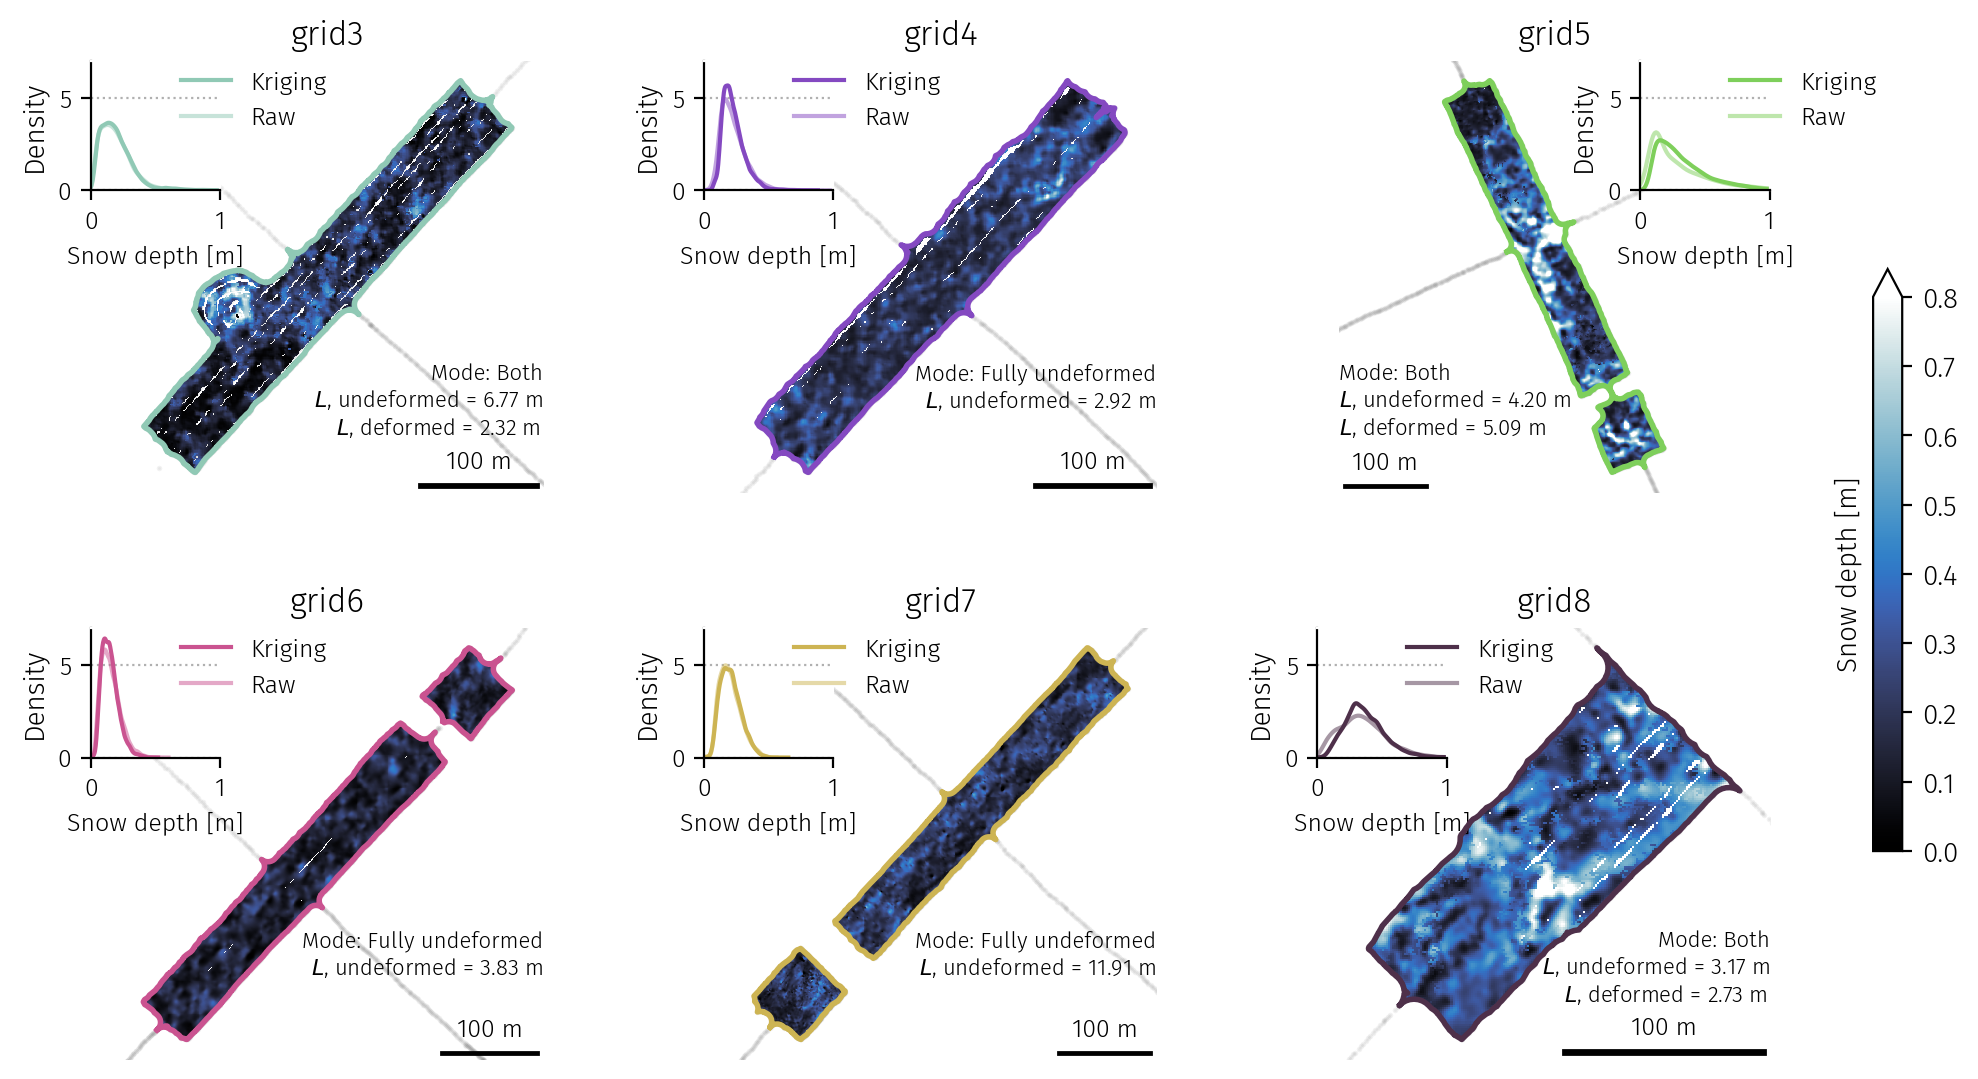

In [4]:
norm = mcolors.Normalize(vmin=0, vmax=.8)
colors = ["#90c9b5",
"#8449c1",
"#7ecf5b",
"#ca5390",
"#cdb453","#4e304a",]
sites_2016 = ['grid3','grid4', 'grid5','grid6','grid7','grid8']
fig, ax = plt.subplots(2,3,figsize=(12,10), constrained_layout=True, dpi=200)   
ax = ax.ravel()
insets = [None]*len(ax)

for ind in range(len(ax)):
    ax[ind].set_aspect('equal')
    ax[ind].set_title(sites_2016[ind])
    ax[ind].axis('off')
    
    if ind == 2:
        insets[ind] = ax[ind].inset_axes([0.7, 0.7, 0.3, 0.3])
    else:
        insets[ind] = ax[ind].inset_axes([-0.05, 0.7, 0.3, 0.3])
    insets[ind].set_xlim(0,1)
    insets[ind].set_ylim(0,7)
    insets[ind].set_xlabel('Snow depth [m]', fontsize=9)
    insets[ind].tick_params(axis='both', which='major', labelsize=9)
    insets[ind].spines['top'].set_color('white')
    insets[ind].spines['right'].set_color('white')
    insets[ind].grid(ls=':',axis='y')
    
for i, site in enumerate(sites_2016):
    df_insitu = df_df.loc[df_df['site_id'] == site]
    
    for geom in shape_dict[site].geometry:
        if type(geom) == shapely.geometry.multipolygon.MultiPolygon:
            for j, g in enumerate(geom):
                ax[i].plot(g.exterior.xy[0], g.exterior.xy[1], color=colors[i], lw=2, zorder=100)
                            # ax[0].plot(shape_dict[site].geometry[0].geoms[0].exterior.xy[0], shape_dict[site].geometry[0].geoms[0].exterior.xy[1], color='black', lw=1, zorder=100, label='Site boundary')
        else:
                ax[i].plot(geom.exterior.xy[0], geom.exterior.xy[1], color=colors[i], lw=2, zorder=100, label='Site boundary')
    
    xlim = ax[i].get_xlim()
    
    width = xlim[1] - xlim[0]
    ylim = ax[i].get_ylim()
    height = ylim[1] - ylim[0]
    diff = height - width
    ax[i].scatter(df_insitu['x'], df_insitu['y'], alpha=.1, s=1,color='grey')
    
    pcol = ax[i].pcolormesh(kriging_dict[site].easting.values, kriging_dict[site].northing.values, kriging_dict[site]['snow_depth'].values,
                     cmap=cmr.arctic,
                     norm=norm
                     )
    clipped = kriging_dict[site].rio.clip([shape_dict[site].geometry[0]])
    
    # ax[i].contour(clipped.easting.values, clipped.northing.values, clipped['classes'].values,
    #               linewidths=.754,
    #               colors=colors[i],
    #               levels=[0.5],
    #             #   alpha=.3,
    #               zorder=200
    #               )
    # ax[i].contourf(clipped.easting.values, clipped.northing.values, clipped['classes'].values,
    #               linewidths=.754,
    #               cmap='Greys',
    #               levels=[0.5,1.5],
    #               alpha=.4,
    #               zorder=100
    #               )

    
    if diff > 0:
        ax[i].set_xlim(xlim[0]-diff/2, xlim[1] + diff/2) 
        ax[i].set_ylim(ylim)
    else:
        ax[i].set_xlim(xlim)
        ax[i].set_ylim(ylim[0]-diff/2, ylim[1] + diff/2)

    
    # sns.histplot(kriging_dict[site]['snow_depth'].values[~np.isnan(kriging_dict[site]['snow_depth'].values)],
    #             bins=np.linspace(0,1,25),
    #             stat='percent',
    #             ax=insets[i],
    #             line_kws={'color':None},
    #             color=colors[i]
    #             )
    sns.kdeplot(kriging_dict[site]['snow_depth'].values[~np.isnan(kriging_dict[site]['snow_depth'].values)],
                # bins=np.linspace(0,1,25),
                # stat='percent',
                ax=insets[i],
                # line_kws={'color':None},
                color=colors[i],
                label='Kriging'
                )
    sns.kdeplot(df_insitu['snow_depth'],
                # bins=np.linspace(0,1,25),
                # stat='percent',
                ax=insets[i],
                # line_kws={'color':None},
                color=colors[i],
                alpha=.5,
                label='Raw'
                )
    insets[i].legend(fontsize=9,
                     loc='upper right',
                     frameon=False,
                     bbox_to_anchor=(2, 1.1)
                     )
    
    
    
    kriging_flag = kriging_dict[site].attrs['kriging_flag'].replace('_',' ').capitalize()
    if kriging_flag == 'Both':
        length_scale_undeformed = kriging_dict[site].attrs['undeformed_range']
        length_scale_deformed = kriging_dict[site].attrs['deformed_range']
        text = f'Mode: {kriging_flag}\n$L$, undeformed = {length_scale_undeformed:.2f} m\n$L$, deformed = {length_scale_deformed:.2f} m '
        
    elif kriging_flag == 'Fully undeformed':
        length_scale_undeformed = kriging_dict[site].attrs['undeformed_range']
        text = f'Mode: {kriging_flag}\n$L$, undeformed = {length_scale_undeformed:.2f} m'
        
    elif kriging_flag == 'Fully deformed':
        length_scale_deformed = kriging_dict[site].attrs['deformed_range']
        text = f'Mode: {kriging_flag}\n$L$, deformed = {length_scale_deformed:.2f} m'
    
    if site == 'grid5':
        ax[i].text(0.0,0.3, text, ha='left', va='top', transform=ax[i].transAxes, size=8)
        scalebar = AnchoredSizeBar(ax[i].transData,
                           100, '100 m', 'lower left', 
                        #    pad=1,
                           color='black',
                           frameon=False,
                           fill_bar=True,
                           size_vertical=2,
                           label_top=True,
                           sep=4,
                           fontproperties=font_manager.FontProperties(family='Fira Sans', size=9)
                           )
    else:    
        ax[i].text(1,0.3, text, ha='right', va='top', transform=ax[i].transAxes, size=8)
        scalebar = AnchoredSizeBar(ax[i].transData,
                           100, '100 m', 'lower right', 
                        #    pad=1,
                           color='black',
                           frameon=False,
                           fill_bar=True,
                           size_vertical=2,
                           label_top=True,
                           sep=4,
                           fontproperties=font_manager.FontProperties(family='Fira Sans', size=9)
                           )
        
        
    ax[i].add_artist(scalebar)
    
    
    
fig.tight_layout(h_pad=-25, w_pad=4)
cbar = fig.colorbar(pcol, ax=ax, orientation='vertical', label='Snow depth [m]', shrink=.3, extend='max')
cbar.ax.yaxis.set_label_position('left')

    # ax[i].plot(shape_dict[site].geometry[0].exterior.xy[0],shape_dict[site].geometry[0].exterior.xy[1])

### ESTIMATING SITE WISE DISTRIBTIONS (LOG-NORMAL, SKEW-NORMAL, ...)